<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [43]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt
import statsmodels.stats.api as sms

In [7]:
# datos
datos=pd.read_csv('data/cookie_cats.csv')
datos.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [15]:
# transformacion
pd.crosstab(datos.version, datos.retention_1)

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [22]:
pd.crosstab(datos.version, datos.retention_7)

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


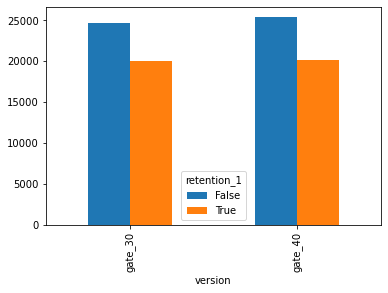

In [24]:
pd.crosstab(datos.version, datos.retention_1).plot(kind='bar');

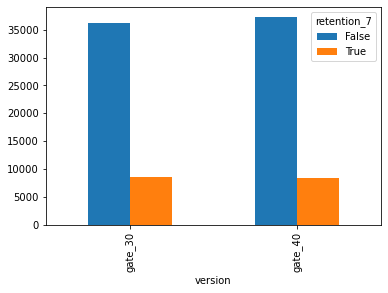

In [25]:
pd.crosstab(datos.version, datos.retention_7).plot(kind='bar');

In [29]:
len(datos[datos['version']=='gate_30'])

44700

In [30]:
len(datos[datos['version']=='gate_40'])

45489

In [31]:
# muestreo
control = datos[datos.version=='gate_30']

tratamiento = datos[datos.version=='gate_40'].sample(n=44700, random_state=22)

ab_test=pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,1066,gate_30,0,False,False
3,2101,gate_30,0,False,False
4,2179,gate_30,39,True,False


In [34]:
# testeo para retention_1
# seleccion de grupos

control_res=ab_test[ab_test.version=='gate_30']['retention_1']

tratamiento_res=ab_test[ab_test.version=='gate_40']['retention_1']

observaciones=[44700, 44700]  #control_res.count()

conversiones=[control_res.sum(), tratamiento_res.sum()]   # conversiones por grupo


z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones)  # diferencia significativa


# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, 
                                                                            nobs=observaciones,
                                                                            alpha=0.05)

In [35]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 1.85
p-valor: 0.064
intervalo conf 95% para grupo control: [0.444, 0.453]
intervalo conf 95% para grupo tratamiento: [0.437, 0.447]


In [36]:
# testeo para retention_7

control_res=ab_test[ab_test.version=='gate_30']['retention_7']

tratamiento_res=ab_test[ab_test.version=='gate_40']['retention_7']

observaciones=[44700, 44700]  #control_res.count()

conversiones=[control_res.sum(), tratamiento_res.sum()]   # conversiones por grupo


z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones)  # diferencia significativa


# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, 
                                                                            nobs=observaciones,
                                                                            alpha=0.05)

In [37]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 3.19
p-valor: 0.001
intervalo conf 95% para grupo control: [0.187, 0.194]
intervalo conf 95% para grupo tratamiento: [0.178, 0.185]


## Conclusiones retention_1
### Dado que el p-valor .064 es mayor a .05, no podemos rechazar la hipótesis nula, lo que significa que la gate 40 no tiene un mejor rendimiento que la gate 30

# Conclusiones retention_7
### Dado que el p-valor .001 es menor que .05 no podemos rechazar la hipótesis nula, lo que significa que la la gate 40 tampoco tiene un mejor rendimiento que la gate 30 con retención de 7 días

